# Measuring time and memory complexity

In [1]:
import torch
import numpy as np
import lab.torch as B

from time import time

import matplotlib.pyplot as plt

from cnp.architectures import (
    UNet,
    StandardDepthwiseSeparableCNN
)

# matplotlib.rcParams['text.usetex'] = True

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

In [3]:
def measure_forward(input_dim, num_points, num_trials, device):

    in_channels = 2
    out_channels = 16
    
    assert torch.cuda.memory_allocated() == 0

    unet = StandardDepthwiseSeparableCNN(
        input_dim=input_dim,
        in_channels=in_channels,
        out_channels=out_channels
    )

    unet = unet.to(device)
    
    unet.requires_grad_(False)
#     unet_forward = B.jit(unet)
    unet_forward = unet.forward

    # Memory measurement
    tensor = torch.zeros(size=[1, in_channels] + [num_points]*input_dim).float().to(device)
    _tensor = unet(tensor).shape

    memory = torch.cuda.memory_allocated()

    # Runtime measurement
    _tensor = unet_forward(tensor)
    
    times = []

    for i in range(num_trials):

        t = time()
        _tensor = unet_forward(tensor)
        print(_tensor.sum())
        times.append(time() - t)

    return memory, np.mean(times), np.var(times)**0.5 / num_trials**0.5

In [4]:
def get_exp_fit(x, y):

    coeff = np.polyfit(x, np.log(y), 1)
    interp = np.poly1d(coeff)
    exp_fit = lambda a: np.exp(interp(a))
    
    return exp_fit

In [5]:
dims = np.arange(1, 4)

# cpu_results = [
#     measure_forward(input_dim=dim, num_points=512, num_trials=2, device='cpu') for dim in dims
# ]
# cpu_results = list(zip(*cpu_results))

gpu_results = [
    measure_forward(input_dim=dim, num_points=128, num_trials=5, device='cuda:0') for dim in dims
]
gpu_results = list(zip(*gpu_results))

tensor(-6.5348, device='cuda:0')
tensor(-6.5348, device='cuda:0')
tensor(-6.5348, device='cuda:0')
tensor(-6.5348, device='cuda:0')
tensor(-6.5348, device='cuda:0')
tensor(1261.3962, device='cuda:0')
tensor(1261.3962, device='cuda:0')
tensor(1261.3962, device='cuda:0')
tensor(1261.3962, device='cuda:0')
tensor(1261.3962, device='cuda:0')
tensor(-59061.3359, device='cuda:0')
tensor(-59061.3359, device='cuda:0')
tensor(-59061.3359, device='cuda:0')
tensor(-59061.3359, device='cuda:0')
tensor(-59061.3359, device='cuda:0')


In [12]:
np_gpu_results = np.array(gpu_results)
np.save('np_gpu_results_nojit.npy', np_gpu_results)

gpu_results = np.load('np_gpu_results_jit.npy')

In [13]:
# cpu_time_mean = np.array(cpu_results[1])
# cpu_time_std = np.array(cpu_results[2])

# exp_fit = get_exp_fit(dims, cpu_time_mean)

# plt.figure(figsize=(12, 4))
# plt.scatter(dims, cpu_time_mean)
# plt.plot(np.arange(1, 5), exp_fit(np.arange(1, 5)))
# plt.errorbar(dims, cpu_time_mean, yerr=cpu_time_std, fmt="x", color='k')
# plt.xlabel("Input dimension $D$", fontsize=18)
# plt.ylabel("CPU log-runtime", fontsize=18)
# plt.xticks(np.arange(1, 5))
# plt.xlim([0.75, 4.25])
# plt.gca().set_yscale("log")
# plt.show()

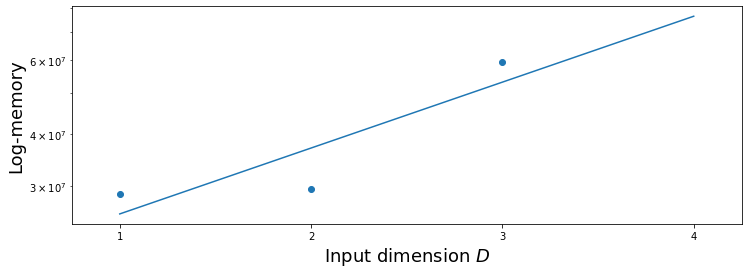

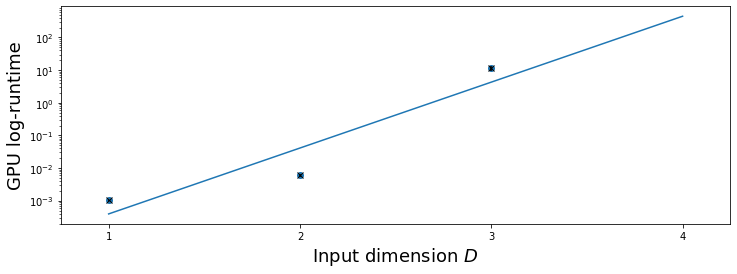

In [14]:
gpu_memory = gpu_results[0]
gpu_time_mean = np.array(gpu_results[1])
gpu_time_std = np.array(gpu_results[2])

exp_fit = get_exp_fit(dims, gpu_memory)

plt.figure(figsize=(12, 4))
plt.scatter(dims, gpu_memory)
plt.plot(np.arange(1, 5), exp_fit(np.arange(1, 5)))
plt.xlabel("Input dimension $D$", fontsize=18)
plt.ylabel("Log-memory", fontsize=18)
plt.xticks(np.arange(1, 5))
plt.xlim([0.75, 4.25])
plt.gca().set_yscale("log")
plt.show()

exp_fit = get_exp_fit(dims, gpu_time_mean)

plt.figure(figsize=(12, 4))
plt.scatter(dims, gpu_time_mean)
plt.plot(np.arange(1, 5), exp_fit(np.arange(1, 5)))
plt.errorbar(dims, gpu_time_mean, yerr=gpu_time_std, fmt="o", marker='x', color='k')
plt.xlabel("Input dimension $D$", fontsize=18)
plt.ylabel("GPU log-runtime", fontsize=18)
plt.xticks(np.arange(1, 5))
plt.xlim([0.75, 4.25])
# plt.ylim([5e-4, 2e-3])
plt.gca().set_yscale("log")
plt.show()